## Discovering transcription factor binding motifs and binding sites in promoter sequences

As we discussed in the introduction session, transcription of DNA into RNA is carried out by the RNA polymerase, which is recruited to the DNA by transcription factors (TFs), proteins that bind specific sequence elements in the DNA. We typically describe the sequence specificity of transcription factors by position-specific weight matrices (PWMs), giving the probabilities of finding each of the four nucleotides at each position of binding sites. Let's see how we can use the HMM framework to describe promoter sequences, find binding sites and infer the PWM of a transcription factor from sequences that contain such binding sites.

### Block 1. Generating synthetic sequence data

Testing with ground truth data is crucial when we develop code. Ground truth biological data is often difficult to obtain, as even the measurement processes are complex, with hard to identify and characterize biases. That is why synthetic data is important: it allows us to determine whether our code works correctly within the assumptions of the model underlying the code. Of course, this does not mean that real data obeys these assumptions, which is why showing that the code works on synthetic data doesn't mean that we have a good tool to analyze real data. Nevertheless, the correctness of the implementation is the first step that we always need to check. So let's generate ourselves a ground truth dataset of "promoter sequences" containing binding sites for a transcription factor.

1. Generate a PWM of your liking
- typical length for eukaryotic TF binding sites is 6-8 nucleotides
- play around with the **bias** of your PWM, i.e. the sequence that has the highest probability under the PWM model
- make sure to write functions that:
    - calculate the information content of the PWM (we'll look into this in a future session)
    - *sample* a binding site from this PWM in proportion to its probability
2. Generate random promoter sequences your chosen A,C,G,T composition.
3. Introduce binding sites sampled from the PWM in the promoter sequences. Keep track of this information to be able to check it later.
4. Check if motif finding software (e.g. MEME, we'll talk about it later as well) recovers the motif you places in your sequence.

### Block 2. Predicting binding sites for TFs with known sequence specificity

1. Implement the forward/backward algorithms. Can you run them on your sequences?
2. Adapt your code to calculate instead ratios of sequence likelihoods (as described in https://cdn.aaai.org/ISMB/2000/ISMB00-007.pdf).
2. Use the functions you implemented to evaluate the posterior probability of binding sites along the promoter sequences you created.
3. Compare your results with your ground truth data.

### Block 3. Training the HMM

Now let's see if we can use the tools we got to actually infer the specificity of the TF from the synthetic data that you generated.

1. Implement the Baum-Welch algorithm to infer the PWM and the transition probability between random sequence and binding sites in promoter sequences (assuming an HMM with 4 states: Start, Random, BindingSite, End).
2. Does it inferred PWM match the one you picked the beginning?


In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seqlogo
# from IPython.display import display, Markdown
from jupyprint import jupyprint, arraytex
from tabulate import tabulate
from pymemesuite.common import Sequence
from pymemesuite.fimo import FIMO

In [77]:
# Generate a random Position probability Matrix based on Dirichlet distribution
def get_random_pwm(composition_bias, tf_length):
    # Dirichlet is generalization of Beta distribution, codomain is [0,1]
    ppm = np.array(np.random.dirichlet(composition_bias, size=(tf_length))).T
    # change dim of composition bias to match counts
    pseudocounts = composition_bias[:, np.newaxis]
    pwm = ppm + pseudocounts
    pwm = pwm / np.sum(pwm, axis=0)
    return pwm, ppm

In [78]:
def get_random_pwm_manual (tf_length: int, 
                    num_seqs: int,
                    composition_bias: list) -> pd.DataFrame:
    """
    Generate a random PWM with a given initial bias.
    """
    # Randomly generate potential promoter PWM with a given initial bias
    dna_letters = ['A', 'C', 'G', 'T']
    dna_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    sequences = []
    for _ in range(0, num_seqs):
        # equal probability (i.e. no bias) when using randint, otherwise use choice distribution to make ppm
        sequence = ''.join([dna_letters[np.random.choice(range(4), p=composition_bias)] for _ in range(tf_length)])
        sequences.append(sequence)
        
    print(f"Randomly generated {num_seqs} sequences of length {tf_length}\nwith composition bias {composition_bias}")

    # count the number of occurrences of each letter in each position
    counts = np.zeros((len(dna_letters), tf_length), dtype=int)
    for sequence in sequences:
        for i, letter in enumerate(sequence):
            counts[dna_dict[letter], i] += 1

    # convert counts to probabilities
    ppm_raw = counts / counts.sum(axis=0)

    # change dim of composition bias to match counts
    pseudocounts = composition_bias[:, np.newaxis]

    # add pseudocount (from composition bias) to raw_ppm before normalizing to pwm
    pwm_raw = (counts + pseudocounts) / (counts.sum(axis=0) + len(dna_letters) * pseudocounts)
    
    return pwm_raw, ppm_raw


Generating random TF binding site of length 8

Background composition bias:
Letter      Bkg comp.
--------  -----------
A                0.25
C                0.25
G                0.25
T                0.25

Position Weight Matrix:
+----+----------+----------+----------+----------+----------+----------+----------+----------+
|    |        0 |        1 |        2 |        3 |        4 |        5 |        6 |        7 |
|----+----------+----------+----------+----------+----------+----------+----------+----------|
| A  | 0.448349 | 0.147838 | 0.125115 | 0.173791 | 0.202512 | 0.535851 | 0.125005 | 0.125022 |
| C  | 0.240977 | 0.125884 | 0.125    | 0.18463  | 0.130731 | 0.172621 | 0.624963 | 0.593117 |
| G  | 0.18398  | 0.125    | 0.143039 | 0.474672 | 0.125691 | 0.166528 | 0.125032 | 0.147268 |
| T  | 0.126694 | 0.601278 | 0.606846 | 0.166908 | 0.541066 | 0.125    | 0.125    | 0.134593 |
+----+----------+----------+----------+----------+----------+----------+----------+----------+

Most p

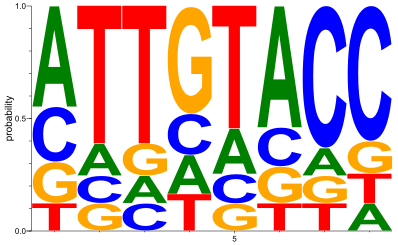

In [79]:
dna_letters = ['A', 'C', 'G', 'T']
# dna_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
tf_length = np.random.randint(6, 9)
print(f"Generating random TF binding site of length {tf_length}")

# This is prior of weight matrix P(w), i.e. dirichelet distribution alpha
# composition_bias = np.array([0.1, 0.3, 0.5, 0.1]) # should sum to 1 for ease of use
composition_bias = np.ones(len(dna_letters))*0.25  # This shouldn't be the for each nucleotide and should instead go by sequence
bck_comp_dict = tabulate(pd.DataFrame(zip(dna_letters, composition_bias)), headers=['Letter', 'Bkg comp.'], showindex=False)
print(f"\nBackground composition bias:\n{bck_comp_dict}")

# # manually randomly generate few potential tf binding site with bckground composition bias
# num_seqs = 5  # keep low to avoid sequence composition approaching initial bias
# pwm_raw, ppm_raw = get_random_pwm_manual(tf_length, num_seqs, composition_bias)

# Get pwm from a ppm generated by dirichlet distribution
pwm_raw, ppm_raw = get_random_pwm(composition_bias, tf_length)

# Create df of pwm and ppm for nice printing
# ppm_df = pd.DataFrame(ppm_raw, index=dna_letters, columns=range(tf_length))
# print(f"\nPosition Probability Matrix:\n{ppm_df}")
pwm_df = pd.DataFrame(pwm_raw, index=dna_letters, columns=range(tf_length))
print(f"\nPosition Weight Matrix:\n{tabulate(pwm_df, headers='keys', tablefmt='psql', showindex=True)}")

# Print most likely sequence from pwm
most_probable_tf_binding_site = ''.join([dna_letters[np.argmax(pwm_raw[:, i])] for i in range(tf_length)])
print(f"\nMost probable TF binding site sequence: {most_probable_tf_binding_site}")

ppm = seqlogo.Ppm(pwm_raw)
seqlogo.seqlogo(ppm, font_size=30, ic_scale=False, format='svg') # attach to axis not working

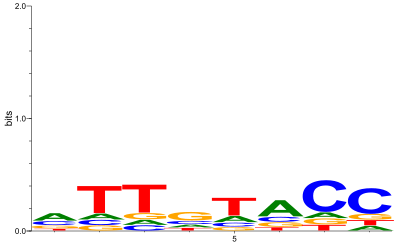

In [80]:
ppm = seqlogo.Ppm(pwm_raw)
seqlogo.seqlogo(ppm, font_size=30, ic_scale=True, format='svg') # attach to axis not working

In [81]:
# calculate information content from pwm
def get_pwm_information_content(pwm, composition_bias):
    bckg_freq = composition_bias[:, np.newaxis]
    ic = np.sum( pwm * np.log2(pwm / bckg_freq), axis=None)
    return ic

def sample_binding_site_from_pwm(pwm, num_samples):
    num_positions = pwm.shape[1]
    # store the sampled sequences
    sampled_sequences = []
    for _ in range(num_samples):
        # For each position, sample a letter based on the PWM probabilities
        sampled_sequence = ''.join(np.random.choice(dna_letters, p=pwm[:, i]) for i in range(num_positions))
        sampled_sequences.append(sampled_sequence)
    return sampled_sequences

In [82]:
# Note that randomly generating motif from Dirichlet often gives too low information content to be useful
ic = get_pwm_information_content(pwm_raw, composition_bias)
print(f"\nInformation content of the PWM: {ic:0.4f} bits")


Information content of the PWM: 2.5416 bits


In [83]:
# sample 10 binding sites and print their associated probabilities
num_samples = 3
sampled_sequences = sample_binding_site_from_pwm(pwm_raw, num_samples)
# Calculate the probabilities of the sampled sequences
sampled_probs = []
for seq in sampled_sequences:
    prob = 1.0
    for i, letter in enumerate(seq):
        prob *= pwm_raw[dna_letters.index(letter), i]
    sampled_probs.append(prob)
# Print the sampled sequences and their probabilities
print("\nSampled sequences and their probabilities:")
for seq, prob in zip(sampled_sequences, sampled_probs):
    print(f"Sequence: {seq}, Probability: {prob:.6f}")


Sampled sequences and their probabilities:
Sequence: ATTGCCTC, Probability: 0.000130
Sequence: CTTTTTGA, Probability: 0.000016
Sequence: AGTCGACC, Probability: 0.000157


In [84]:
# Create a random sequence of length between 150 to 200 given the background composition bias and add sampled sequences at random positions
def create_random_sequence_with_sampled_sites(length, composition_bias, sampled_sequences):
    # Generate a random sequence with the given length and background composition bias
    random_sequence = ''.join(np.random.choice(dna_letters, size=length, p=composition_bias))

    tf_positions = []
    
    # Randomly select positions to insert the sampled sequences
    for seq in sampled_sequences:
        pos = np.random.randint(0, length - len(seq) + 1)
        tf_positions.append(pos)
        random_sequence = random_sequence[:pos] + seq + random_sequence[pos + len(seq):]
    
    return random_sequence, tf_positions

In [85]:
# Create and print random sequence with sampled sites
random_sequence, tf_positions = create_random_sequence_with_sampled_sites(200, composition_bias, sampled_sequences)
print(f"\nRandom sequence with sampled binding sites:\n{random_sequence}")
print(f"Sampled binding sites inserted at positions: {tf_positions}")


Random sequence with sampled binding sites:
AGGACATCTACTTCGTCGTTGAATGGCCGCAATCCCAGCTTTTTGACGCTGGTTGTGGCCCTCAAAGTGCGGACACTCCGAACGTAATAGGACGCATGTTGCATTTTCCTATCATAGTCGACCCTCCAGGCGGTAAATCACCCGTGTGGAAGATCCGCTCGAGATTAAAAATTGCCTCAGGGCATCAATTATTCTCGGTT
Sampled binding sites inserted at positions: [170, 38, 115]
